In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_BN_2(conv_num=1):
    kernel_size = 64
    filter_size = 64
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3*kernel_size, filters=filter_size, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        target_kernel_size = 3 * (kernel_size//(2**(i+1)))
        model.add(Conv1D (kernel_size=target_kernel_size if target_kernel_size != 0 else 3, 
                          filters=filter_size*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())    
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_BN_2(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 1024000)           4096000   
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 20,492,624
Trainable params: 18,444,496
Non-trainable pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_44 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 12.6272 - acc: 0.1886
Epoch 00001: val_loss improved from inf to 12.22745, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_1_conv_checkpoint/001-12.2275.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 12.6273 - acc: 0.1886 - val_loss: 12.2275 - val_acc: 0.2127
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 11.2456 - acc: 0.2811
Epoch 00002: val_loss improved from 12.22745 to 11.15144, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_1_conv_checkpoint/002-11.1514.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 11.2463 - acc: 0.2811 - val_loss: 11.1514 - val_acc: 0.2888
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 10.5700 - acc: 0.3256
Epoch 00003: val_loss improved from 11.15144 to 1

36805/36805 [==============================] - 56s 2ms/sample - loss: 6.7400 - acc: 0.5717 - val_loss: 8.5094 - val_acc: 0.4580
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.7441 - acc: 0.5718
Epoch 00024: val_loss did not improve from 8.50944
36805/36805 [==============================] - 55s 1ms/sample - loss: 6.7440 - acc: 0.5718 - val_loss: 8.5573 - val_acc: 0.4517
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.6809 - acc: 0.5754
Epoch 00025: val_loss did not improve from 8.50944
36805/36805 [==============================] - 55s 2ms/sample - loss: 6.6817 - acc: 0.5754 - val_loss: 8.5379 - val_acc: 0.4573
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.7123 - acc: 0.5733
Epoch 00026: val_loss improved from 8.50944 to 8.43398, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_1_conv_checkpoint/026-8.4340.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 6.

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.6383 - acc: 0.6431
Epoch 00051: val_loss did not improve from 8.08002
36805/36805 [==============================] - 55s 1ms/sample - loss: 5.6393 - acc: 0.6431 - val_loss: 8.2960 - val_acc: 0.4733
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.4989 - acc: 0.6528
Epoch 00052: val_loss did not improve from 8.08002
36805/36805 [==============================] - 55s 2ms/sample - loss: 5.4994 - acc: 0.6528 - val_loss: 8.1504 - val_acc: 0.4857
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.4869 - acc: 0.6534
Epoch 00053: val_loss did not improve from 8.08002
36805/36805 [==============================] - 55s 1ms/sample - loss: 5.4877 - acc: 0.6533 - val_loss: 8.1183 - val_acc: 0.4871
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.4295 - acc: 0.6571
Epoch 00054: val_loss did not improve from 8.08002
36805/36805 [===========

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.4705 - acc: 0.7172
Epoch 00079: val_loss improved from 7.73575 to 7.58430, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_1_conv_checkpoint/079-7.5843.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 4.4712 - acc: 0.7172 - val_loss: 7.5843 - val_acc: 0.5188
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.5633 - acc: 0.7114
Epoch 00080: val_loss did not improve from 7.58430
36805/36805 [==============================] - 55s 1ms/sample - loss: 4.5640 - acc: 0.7113 - val_loss: 7.7438 - val_acc: 0.5071
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.4617 - acc: 0.7174
Epoch 00081: val_loss improved from 7.58430 to 7.51669, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_1_conv_checkpoint/081-7.5167.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 4.4620 - acc: 0.7174 - val_los

36800/36805 [============================>.] - ETA: 0s - loss: 3.6540 - acc: 0.7688
Epoch 00107: val_loss did not improve from 7.21904
36805/36805 [==============================] - 55s 1ms/sample - loss: 3.6544 - acc: 0.7687 - val_loss: 7.2846 - val_acc: 0.5374
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.5800 - acc: 0.7733
Epoch 00108: val_loss did not improve from 7.21904
36805/36805 [==============================] - 55s 1ms/sample - loss: 3.5808 - acc: 0.7732 - val_loss: 7.4155 - val_acc: 0.5309
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.5812 - acc: 0.7735
Epoch 00109: val_loss did not improve from 7.21904
36805/36805 [==============================] - 55s 1ms/sample - loss: 3.5812 - acc: 0.7735 - val_loss: 7.4814 - val_acc: 0.5262
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.7032 - acc: 0.7651
Epoch 00110: val_loss did not improve from 7.21904
36805/36805 [=====================

Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.2451 - acc: 0.7953
Epoch 00137: val_loss did not improve from 7.21904
36805/36805 [==============================] - 55s 2ms/sample - loss: 3.2460 - acc: 0.7952 - val_loss: 7.3830 - val_acc: 0.5327
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.2311 - acc: 0.7958
Epoch 00138: val_loss did not improve from 7.21904
36805/36805 [==============================] - 55s 1ms/sample - loss: 3.2316 - acc: 0.7958 - val_loss: 7.3697 - val_acc: 0.5337
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.2339 - acc: 0.7958
Epoch 00139: val_loss did not improve from 7.21904
36805/36805 [==============================] - 55s 1ms/sample - loss: 3.2344 - acc: 0.7958 - val_loss: 7.3711 - val_acc: 0.5341

1D_CNN_custom_kernel_192_BN_1_conv Model


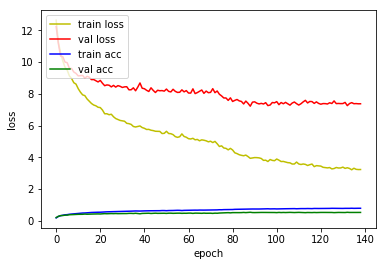

4815/4815 [==============================] - 3s 646us/sample - loss: 7.7689 - acc: 0.5080
Loss: 7.7689363844050545 Accuracy: 0.50799584

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.3732 - acc: 0.3733
Epoch 00001: val_loss improved from inf to 4.68530, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_2_conv_checkpoint/001-4.6853.hdf5
36805/36805 [==============================] - 180s 5ms/sample - loss: 4.3732 - acc: 0.3733 - val_loss: 4.6853 - val_acc: 0.3545
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1855 - acc: 0.5924
Epoch 00002: val_loss improved from 4.68530 to 4.33780, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_2_conv_checkpoint/002-4.3378.hdf5
36805/36805 [==============================] - 178s 5ms/sample - loss: 3.1857 - acc: 0.5924 - val_loss: 4.3378 - val_acc: 0.4864
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

36800/36805 [============================>.] - ETA: 0s - loss: 0.6618 - acc: 0.9426
Epoch 00029: val_loss did not improve from 4.33780
36805/36805 [==============================] - 178s 5ms/sample - loss: 0.6617 - acc: 0.9426 - val_loss: 5.4583 - val_acc: 0.5770
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6172 - acc: 0.9468
Epoch 00030: val_loss did not improve from 4.33780
36805/36805 [==============================] - 178s 5ms/sample - loss: 0.6178 - acc: 0.9468 - val_loss: 6.1215 - val_acc: 0.5290
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6347 - acc: 0.9443
Epoch 00031: val_loss did not improve from 4.33780
36805/36805 [==============================] - 178s 5ms/sample - loss: 0.6352 - acc: 0.9442 - val_loss: 5.8845 - val_acc: 0.5539
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6342 - acc: 0.9468
Epoch 00032: val_loss did not improve from 4.33780
36805/36805 [=====================

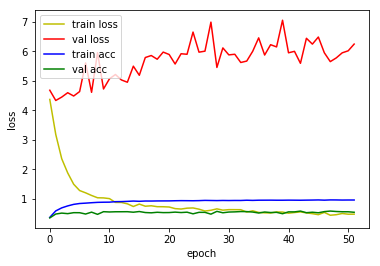

4815/4815 [==============================] - 5s 1ms/sample - loss: 4.4027 - acc: 0.4667
Loss: 4.402662525642451 Accuracy: 0.46666667

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4923 - acc: 0.4124
Epoch 00001: val_loss improved from inf to 2.34501, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_3_conv_checkpoint/001-2.3450.hdf5
36805/36805 [==============================] - 207s 6ms/sample - loss: 2.4921 - acc: 0.4125 - val_loss: 2.3450 - val_acc: 0.4041
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6253 - acc: 0.6181
Epoch 00002: val_loss did not improve from 2.34501
36805/36805 [==============================] - 203s 6ms/sample - loss: 1.6252 - acc: 0.6181 - val_loss: 2.5557 - val_acc: 0.5008
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0618 - acc: 0.7340
Epoch 00003: val_loss did not improve from 2.34501
36805/36805 [=========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1109 - acc: 0.9776
Epoch 00029: val_loss did not improve from 2.11866
36805/36805 [==============================] - 204s 6ms/sample - loss: 0.1111 - acc: 0.9776 - val_loss: 3.0219 - val_acc: 0.6273
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1197 - acc: 0.9756
Epoch 00030: val_loss did not improve from 2.11866
36805/36805 [==============================] - 203s 6ms/sample - loss: 0.1198 - acc: 0.9756 - val_loss: 3.0401 - val_acc: 0.6243
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1055 - acc: 0.9799
Epoch 00031: val_loss did not improve from 2.11866
36805/36805 [==============================] - 203s 6ms/sample - loss: 0.1056 - acc: 0.9799 - val_loss: 3.1434 - val_acc: 0.6324
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0925 - acc: 0.9829
Epoch 00032: val_loss did not improve from 2.11866
36805/36805 [=====================

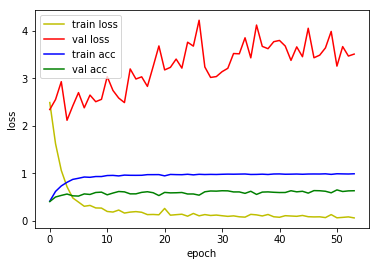

4815/4815 [==============================] - 6s 1ms/sample - loss: 2.2687 - acc: 0.5346
Loss: 2.26870874704973 Accuracy: 0.53457946

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8907 - acc: 0.4565
Epoch 00001: val_loss improved from inf to 1.73658, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_4_conv_checkpoint/001-1.7366.hdf5
36805/36805 [==============================] - 213s 6ms/sample - loss: 1.8907 - acc: 0.4565 - val_loss: 1.7366 - val_acc: 0.4663
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2723 - acc: 0.6414
Epoch 00002: val_loss improved from 1.73658 to 1.64464, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_4_conv_checkpoint/002-1.6446.hdf5
36805/36805 [==============================] - 209s 6ms/sample - loss: 1.2723 - acc: 0.6414 - val_loss: 1.6446 - val_acc: 0.5611
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.0534 - acc: 0.9872
Epoch 00028: val_loss did not improve from 0.88020
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0534 - acc: 0.9872 - val_loss: 1.4152 - val_acc: 0.7515
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0677 - acc: 0.9837
Epoch 00029: val_loss did not improve from 0.88020
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0677 - acc: 0.9837 - val_loss: 1.5032 - val_acc: 0.7244
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0545 - acc: 0.9877
Epoch 00030: val_loss did not improve from 0.88020
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0546 - acc: 0.9877 - val_loss: 1.4254 - val_acc: 0.7345
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0779 - acc: 0.9802
Epoch 00031: val_loss did not improve from 0.88020
36805/36805 [=====================

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 0.9917
Epoch 00058: val_loss did not improve from 0.88020
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0346 - acc: 0.9916 - val_loss: 1.4226 - val_acc: 0.7904

1D_CNN_custom_kernel_192_BN_4_conv Model


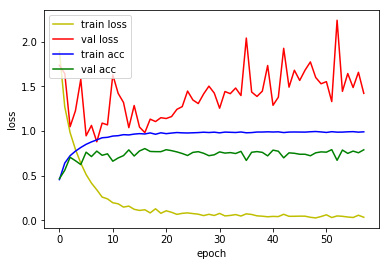

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.9789 - acc: 0.7423
Loss: 0.9789011884948794 Accuracy: 0.74226373

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7633 - acc: 0.4760
Epoch 00001: val_loss improved from inf to 1.91465, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_5_conv_checkpoint/001-1.9147.hdf5
36805/36805 [==============================] - 222s 6ms/sample - loss: 1.7635 - acc: 0.4760 - val_loss: 1.9147 - val_acc: 0.4472
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1184 - acc: 0.6732
Epoch 00002: val_loss improved from 1.91465 to 1.54245, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_5_conv_checkpoint/002-1.5425.hdf5
36805/36805 [==============================] - 215s 6ms/sample - loss: 1.1188 - acc: 0.6731 - val_loss: 1.5425 - val_acc: 0.6003
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0831 - acc: 0.9746
Epoch 00027: val_loss did not improve from 0.63447
36805/36805 [==============================] - 215s 6ms/sample - loss: 0.0831 - acc: 0.9747 - val_loss: 0.7087 - val_acc: 0.8640
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0601 - acc: 0.9840
Epoch 00028: val_loss did not improve from 0.63447
36805/36805 [==============================] - 215s 6ms/sample - loss: 0.0601 - acc: 0.9841 - val_loss: 0.7881 - val_acc: 0.8418
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0641 - acc: 0.9822
Epoch 00029: val_loss did not improve from 0.63447
36805/36805 [==============================] - 215s 6ms/sample - loss: 0.0641 - acc: 0.9821 - val_loss: 0.7745 - val_acc: 0.8493
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0822 - acc: 0.9761
Epoch 00030: val_loss did not improve from 0.63447
36805/36805 [========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0616 - acc: 0.9839
Epoch 00057: val_loss did not improve from 0.63447
36805/36805 [==============================] - 215s 6ms/sample - loss: 0.0616 - acc: 0.9839 - val_loss: 0.8152 - val_acc: 0.8535
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.9936
Epoch 00058: val_loss did not improve from 0.63447
36805/36805 [==============================] - 215s 6ms/sample - loss: 0.0265 - acc: 0.9936 - val_loss: 0.7680 - val_acc: 0.8672
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0468 - acc: 0.9875
Epoch 00059: val_loss did not improve from 0.63447
36805/36805 [==============================] - 215s 6ms/sample - loss: 0.0470 - acc: 0.9874 - val_loss: 0.7409 - val_acc: 0.8761
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0547 - acc: 0.9860
Epoch 00060: val_loss did not improve from 0.63447
36805/36805 [========

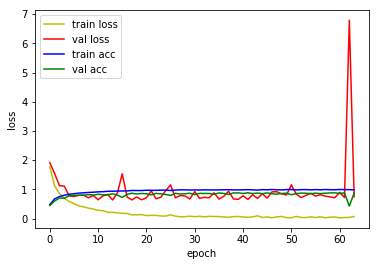

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.7346 - acc: 0.8258
Loss: 0.7346186304389501 Accuracy: 0.82575285

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7416 - acc: 0.4602
Epoch 00001: val_loss improved from inf to 1.56320, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_6_conv_checkpoint/001-1.5632.hdf5
36805/36805 [==============================] - 226s 6ms/sample - loss: 1.7418 - acc: 0.4602 - val_loss: 1.5632 - val_acc: 0.5087
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0962 - acc: 0.6683
Epoch 00002: val_loss improved from 1.56320 to 0.98896, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_6_conv_checkpoint/002-0.9890.hdf5
36805/36805 [==============================] - 216s 6ms/sample - loss: 1.0961 - acc: 0.6683 - val_loss: 0.9890 - val_acc: 0.7016
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0875 - acc: 0.9746
Epoch 00026: val_loss improved from 0.34905 to 0.32304, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_6_conv_checkpoint/026-0.3230.hdf5
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0875 - acc: 0.9746 - val_loss: 0.3230 - val_acc: 0.9199
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0670 - acc: 0.9815
Epoch 00027: val_loss did not improve from 0.32304
36805/36805 [==============================] - 216s 6ms/sample - loss: 0.0670 - acc: 0.9815 - val_loss: 0.4289 - val_acc: 0.8926
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0589 - acc: 0.9848
Epoch 00028: val_loss did not improve from 0.32304
36805/36805 [==============================] - 216s 6ms/sample - loss: 0.0589 - acc: 0.9847 - val_loss: 0.4698 - val_acc: 0.8887
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0700

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9910
Epoch 00055: val_loss did not improve from 0.32302
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0329 - acc: 0.9910 - val_loss: 0.3843 - val_acc: 0.9189
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9925
Epoch 00056: val_loss did not improve from 0.32302
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0311 - acc: 0.9925 - val_loss: 0.4120 - val_acc: 0.9192
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9933
Epoch 00057: val_loss did not improve from 0.32302
36805/36805 [==============================] - 216s 6ms/sample - loss: 0.0253 - acc: 0.9933 - val_loss: 0.3717 - val_acc: 0.9262
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9934
Epoch 00058: val_loss did not improve from 0.32302
36805/36805 [========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0229 - acc: 0.9936
Epoch 00085: val_loss did not improve from 0.32302
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0229 - acc: 0.9936 - val_loss: 0.3709 - val_acc: 0.9299
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0094 - acc: 0.9984
Epoch 00086: val_loss did not improve from 0.32302
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0095 - acc: 0.9984 - val_loss: 0.4157 - val_acc: 0.9217
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9926
Epoch 00087: val_loss did not improve from 0.32302
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0261 - acc: 0.9926 - val_loss: 0.3769 - val_acc: 0.9280
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0106 - acc: 0.9980
Epoch 00088: val_loss did not improve from 0.32302
36805/36805 [========

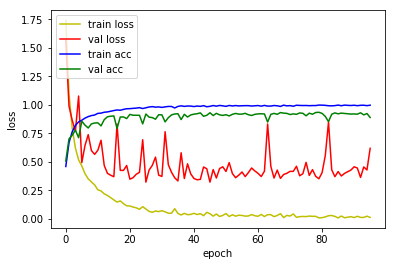

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3701 - acc: 0.9088
Loss: 0.3701478431157977 Accuracy: 0.9088266

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8262 - acc: 0.4332
Epoch 00001: val_loss improved from inf to 1.65572, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_7_conv_checkpoint/001-1.6557.hdf5
36805/36805 [==============================] - 231s 6ms/sample - loss: 1.8261 - acc: 0.4332 - val_loss: 1.6557 - val_acc: 0.4743
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0894 - acc: 0.6714
Epoch 00002: val_loss improved from 1.65572 to 0.90594, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_7_conv_checkpoint/002-0.9059.hdf5
36805/36805 [==============================] - 217s 6ms/sample - loss: 1.0893 - acc: 0.6714 - val_loss: 0.9059 - val_acc: 0.7261
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0709 - acc: 0.9799
Epoch 00027: val_loss did not improve from 0.22838
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0709 - acc: 0.9798 - val_loss: 0.2617 - val_acc: 0.9290
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0735 - acc: 0.9794
Epoch 00028: val_loss improved from 0.22838 to 0.22373, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_7_conv_checkpoint/028-0.2237.hdf5
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0736 - acc: 0.9794 - val_loss: 0.2237 - val_acc: 0.9378
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0623 - acc: 0.9824
Epoch 00029: val_loss improved from 0.22373 to 0.22150, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_7_conv_checkpoint/029-0.2215.hdf5
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0624 - acc: 0.9824 - val_

36800/36805 [============================>.] - ETA: 0s - loss: 0.0136 - acc: 0.9978
Epoch 00055: val_loss did not improve from 0.19189
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0136 - acc: 0.9978 - val_loss: 0.2088 - val_acc: 0.9490
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.9959
Epoch 00056: val_loss did not improve from 0.19189
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0179 - acc: 0.9959 - val_loss: 0.3032 - val_acc: 0.9341
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0250 - acc: 0.9936
Epoch 00057: val_loss did not improve from 0.19189
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0250 - acc: 0.9936 - val_loss: 0.2552 - val_acc: 0.9385
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0198 - acc: 0.9952
Epoch 00058: val_loss did not improve from 0.19189
36805/36805 [=====================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9966
Epoch 00085: val_loss did not improve from 0.19189
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0136 - acc: 0.9966 - val_loss: 0.2401 - val_acc: 0.9506
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0163 - acc: 0.9957
Epoch 00086: val_loss did not improve from 0.19189
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0163 - acc: 0.9957 - val_loss: 0.2104 - val_acc: 0.9515
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9987
Epoch 00087: val_loss did not improve from 0.19189
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0075 - acc: 0.9987 - val_loss: 0.2091 - val_acc: 0.9525
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0186 - acc: 0.9951
Epoch 00088: val_loss did not improve from 0.19189
36805/36805 [========

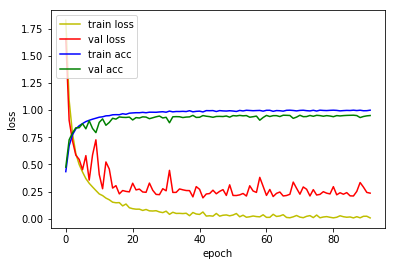

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.2482 - acc: 0.9321
Loss: 0.24817572193972665 Accuracy: 0.93208724

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7820 - acc: 0.4566
Epoch 00001: val_loss improved from inf to 1.56385, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_8_conv_checkpoint/001-1.5638.hdf5
36805/36805 [==============================] - 235s 6ms/sample - loss: 1.7820 - acc: 0.4566 - val_loss: 1.5638 - val_acc: 0.5213
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9653 - acc: 0.7127
Epoch 00002: val_loss improved from 1.56385 to 0.84992, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_8_conv_checkpoint/002-0.8499.hdf5
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.9653 - acc: 0.7126 - val_loss: 0.8499 - val_acc: 0.7396
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9857
Epoch 00026: val_loss did not improve from 0.15234
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0540 - acc: 0.9857 - val_loss: 0.2134 - val_acc: 0.9401
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0488 - acc: 0.9879
Epoch 00027: val_loss did not improve from 0.15234
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0489 - acc: 0.9879 - val_loss: 0.1950 - val_acc: 0.9446
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0590 - acc: 0.9842
Epoch 00028: val_loss did not improve from 0.15234
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0589 - acc: 0.9842 - val_loss: 0.1636 - val_acc: 0.9543
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9931
Epoch 00029: val_loss improved from 0.15234 to 0.14649, saving model to 

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0096 - acc: 0.9982
Epoch 00055: val_loss did not improve from 0.14143
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0096 - acc: 0.9982 - val_loss: 0.3297 - val_acc: 0.9136
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9904
Epoch 00056: val_loss did not improve from 0.14143
36805/36805 [==============================] - 220s 6ms/sample - loss: 0.0316 - acc: 0.9903 - val_loss: 0.1714 - val_acc: 0.9560
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0278 - acc: 0.9924
Epoch 00057: val_loss did not improve from 0.14143
36805/36805 [==============================] - 220s 6ms/sample - loss: 0.0279 - acc: 0.9924 - val_loss: 0.1771 - val_acc: 0.9567
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9948
Epoch 00058: val_loss did not improve from 0.14143
36805/36805 [========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0050 - acc: 0.9993
Epoch 00085: val_loss did not improve from 0.14143
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0050 - acc: 0.9993 - val_loss: 0.1765 - val_acc: 0.9590
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9980
Epoch 00086: val_loss did not improve from 0.14143
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0086 - acc: 0.9980 - val_loss: 0.1669 - val_acc: 0.9583

1D_CNN_custom_kernel_192_BN_8_conv Model


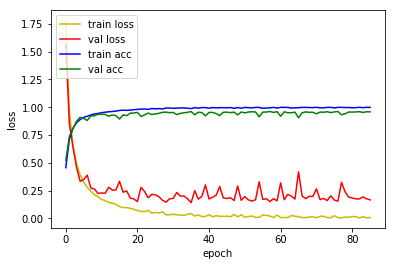

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.1914 - acc: 0.9472
Loss: 0.19141930490267983 Accuracy: 0.94724816

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3665 - acc: 0.5784
Epoch 00001: val_loss improved from inf to 1.28232, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_9_conv_checkpoint/001-1.2823.hdf5
36805/36805 [==============================] - 241s 7ms/sample - loss: 1.3665 - acc: 0.5783 - val_loss: 1.2823 - val_acc: 0.5765
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5945 - acc: 0.8232
Epoch 00002: val_loss improved from 1.28232 to 0.61571, saving model to model/checkpoint/1D_CNN_custom_kernel_192_BN_9_conv_checkpoint/002-0.6157.hdf5
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.5945 - acc: 0.8232 - val_loss: 0.6157 - val_acc: 0.8153
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9927
Epoch 00026: val_loss did not improve from 0.12134
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0297 - acc: 0.9927 - val_loss: 0.1576 - val_acc: 0.9550
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9941
Epoch 00027: val_loss did not improve from 0.12134
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0244 - acc: 0.9941 - val_loss: 0.1630 - val_acc: 0.9550
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0243 - acc: 0.9943
Epoch 00028: val_loss did not improve from 0.12134
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0244 - acc: 0.9942 - val_loss: 0.2410 - val_acc: 0.9271
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0476 - acc: 0.9862
Epoch 00029: val_loss did not improve from 0.12134
36805/36805 [=====================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0070 - acc: 0.9983
Epoch 00056: val_loss did not improve from 0.12134
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0070 - acc: 0.9983 - val_loss: 0.1725 - val_acc: 0.9536
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9978
Epoch 00057: val_loss did not improve from 0.12134
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0089 - acc: 0.9978 - val_loss: 0.1560 - val_acc: 0.9588
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9981
Epoch 00058: val_loss did not improve from 0.12134
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0084 - acc: 0.9981 - val_loss: 0.1505 - val_acc: 0.9646
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9959
Epoch 00059: val_loss did not improve from 0.12134
36805/36805 [========

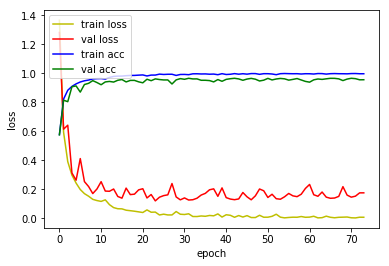

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.1784 - acc: 0.9516
Loss: 0.17835679398085594 Accuracy: 0.95160955



In [10]:
for i in range(1, 10):
    base = '1D_CNN_custom_kernel_192_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_BN_2(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_kernel_192_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_kernel_192_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_55 (B (None, 1024000)           4096000   
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 20,492,624
Trainable params: 18,444,496
Non-trainable params: 2,048,128
______________

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.9789 - acc: 0.7423
Loss: 0.9789011884948794 Accuracy: 0.74226373

1D_CNN_custom_kernel_192_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
batch_normalization_v1_69 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (No

4815/4815 [==============================] - 7s 2ms/sample - loss: 0.2482 - acc: 0.9321
Loss: 0.24817572193972665 Accuracy: 0.93208724

1D_CNN_custom_kernel_192_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)   (N

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.1784 - acc: 0.9516
Loss: 0.17835679398085594 Accuracy: 0.95160955


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_kernel_192_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_kernel_192_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_55 (B (None, 1024000)           4096000   
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 20,492,624
Trainable params: 18,444,496
Non-trainable params: 2,048,128
______________

4815/4815 [==============================] - 8s 2ms/sample - loss: 1.6357 - acc: 0.7576
Loss: 1.6356533436265195 Accuracy: 0.7576324

1D_CNN_custom_kernel_192_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
batch_normalization_v1_69 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (Non

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.3025 - acc: 0.9346
Loss: 0.3025357089604049 Accuracy: 0.93457943

1D_CNN_custom_kernel_192_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)   (No

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.2526 - acc: 0.9402
Loss: 0.2526039500189858 Accuracy: 0.9401869
